In [ ]:
import geopandas as gpd

cr_points = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/CostaRica_Coffee_points.geojson")
detections = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_prob_0.9_postprocess.parquet")
detections_5 = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_prob_0.5_postprocess.parquet")

In [3]:
def buffer_points_in_utm(points_gdf, buffer_size=100):
    """
    Buffer points using appropriate UTM projection.
    
    Parameters:
        points_gdf (GeoDataFrame): GeoDataFrame containing point geometries
        buffer_size (float): Buffer size in meters
        
    Returns:
        GeoDataFrame: GeoDataFrame with buffered geometries
    """
    # Get the center of the bounds
    bounds = points_gdf.total_bounds
    center_lon = (bounds[0] + bounds[2]) / 2
    center_lat = (bounds[1] + bounds[3]) / 2
    
    # Calculate UTM zone from longitude
    utm_zone = int(((center_lon + 180) / 6) % 60) + 1
    
    # Determine if northern or southern hemisphere
    epsg = 32600 + utm_zone if center_lat >= 0 else 32700 + utm_zone
    
    # Project to UTM
    points_utm = points_gdf.to_crs(epsg=epsg)
    
    # Buffer the points
    buffered_points_utm = points_utm.copy()
    buffered_points_utm['geometry'] = points_utm.geometry.buffer(buffer_size)
    
    # Project back to original CRS
    buffered_points = buffered_points_utm.to_crs(points_gdf.crs)
    
    return buffered_points

# Example usage
buffered_cr_points = buffer_points_in_utm(cr_points, buffer_size=100)


In [9]:
# Count how many buffered points intersect with detection polygons
intersecting_points = buffered_cr_points.sjoin(detections, predicate='intersects', how='inner')
intersecting_points_5 = buffered_cr_points.sjoin(detections_5, predicate='intersects', how='inner')

print(f"Number of buffered points that intersect with detection polygons: {len(intersecting_points)}")
print(f"Number of buffered points that intersect with detection polygons (probability threshold 0.5): {len(intersecting_points_5)}")
print(f"Percentage of total points: {len(intersecting_points) / len(buffered_cr_points) * 100:.2f}%")
print(f"Percentage of total points (probability threshold 0.5): {len(intersecting_points_5) / len(buffered_cr_points) * 100:.2f}%")



Number of buffered points that intersect with detection polygons: 6484
Number of buffered points that intersect with detection polygons (probability threshold 0.5): 6914
Percentage of total points: 81.22%
Percentage of total points (probability threshold 0.5): 86.61%


100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


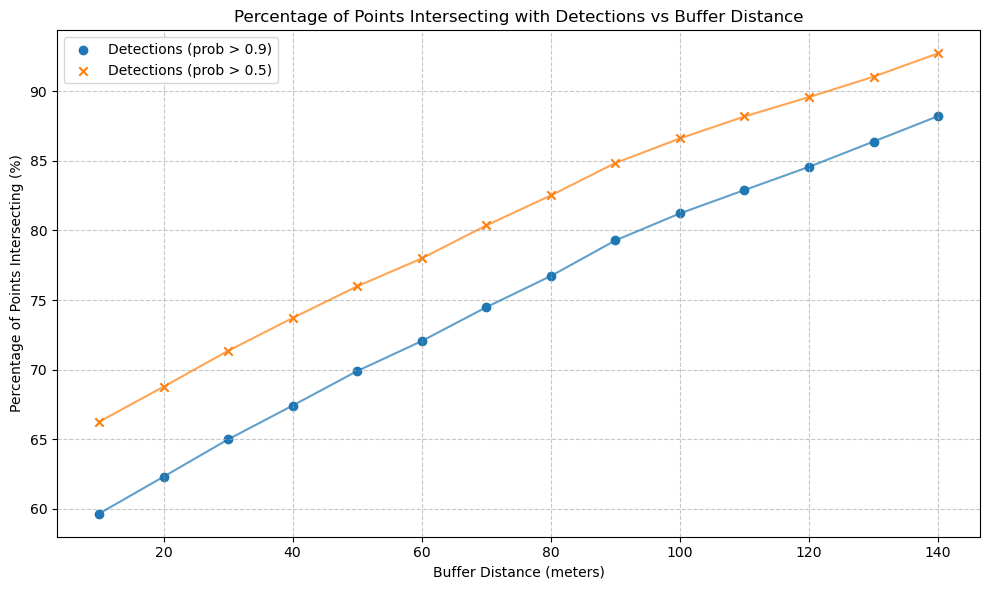

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create a range of buffer distances
buffer_distances = range(10, 150, 10)

# Lists to store results
percentages = []
percentages_5 = []

# Calculate intersection percentages for each buffer distance
for distance in tqdm(buffer_distances):
    # Buffer points with current distance
    buffered_points = buffer_points_in_utm(cr_points, buffer_size=distance)
    
    # Count intersections
    intersecting = buffered_points.sjoin(detections, predicate='intersects', how='inner')
    intersecting_5 = buffered_points.sjoin(detections_5, predicate='intersects', how='inner')
    
    # Calculate percentages
    percent = len(intersecting) / len(buffered_points) * 100
    percent_5 = len(intersecting_5) / len(buffered_points) * 100
    
    # Store results
    percentages.append(percent)
    percentages_5.append(percent_5)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(buffer_distances, percentages, label='Detections (prob > 0.9)', marker='o')
plt.scatter(buffer_distances, percentages_5, label='Detections (prob > 0.5)', marker='x')

# Connect points with lines
plt.plot(buffer_distances, percentages, linestyle='-', alpha=0.7)
plt.plot(buffer_distances, percentages_5, linestyle='-', alpha=0.7)

# Add labels and title
plt.xlabel('Buffer Distance (meters)')
plt.ylabel('Percentage of Points Intersecting (%)')
plt.title('Percentage of Points Intersecting with Detections vs Buffer Distance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
mesoamerica_detections_5 = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_mesoamerica_posw1.0_prob_0.5_postprocess.parquet")
mesoamerica_detections = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_mesoamerica_posw1.0_prob_0.9_postprocess.parquet")
mesoamerica_polygons = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/central_america_coffee_polygons.geojson")


/tmp/ipykernel_2479130/2369595766.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_polygons_union = mesoamerica_polygons.unary_union
/tmp/ipykernel_2479130/2369595766.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_detections_union = mesoamerica_detections.unary_union
/tmp/ipykernel_2479130/2369595766.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesoamerica_detections_5_union = mesoamerica_detections_5.unary_union


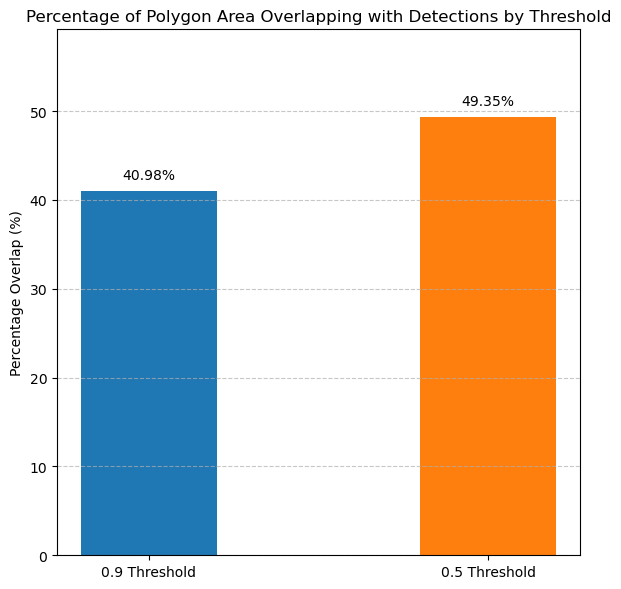

In [19]:
# Calculate unary unions
mesoamerica_polygons_union = mesoamerica_polygons.unary_union
mesoamerica_detections_union = mesoamerica_detections.unary_union
mesoamerica_detections_5_union = mesoamerica_detections_5.unary_union

# Calculate intersection areas
intersection_09 = mesoamerica_polygons_union.intersection(mesoamerica_detections_union)
intersection_05 = mesoamerica_polygons_union.intersection(mesoamerica_detections_5_union)

# Calculate areas
mesoamerica_area = mesoamerica_polygons_union.area
intersection_09_area = intersection_09.area
intersection_05_area = intersection_05.area

# Calculate overlap percentages
pct_overlap_09 = (intersection_09_area / mesoamerica_area) * 100
pct_overlap_05 = (intersection_05_area / mesoamerica_area) * 100

# Create bar chart with thinner bars
fig, ax = plt.figure(figsize=(6, 6)), plt.gca()
thresholds = ['0.9 Threshold', '0.5 Threshold']
percentages = [pct_overlap_09, pct_overlap_05]
bars = ax.bar(thresholds, percentages, color=['#1f77b4', '#ff7f0e'], width=0.4)

# Add data labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.2f}%',
            ha='center', va='bottom')

# Add chart labels
ax.set_title('Percentage of Polygon Area Overlapping with Detections by Threshold')
ax.set_ylabel('Percentage Overlap (%)')
ax.set_ylim(0, max(percentages) * 1.2)  # Add some space for the labels
ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Add text with total area
# ax.text(0.02, 0.95, f'Total polygon area: {mesoamerica_area:.2f} sq units', transform=ax.transAxes,
#         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()